# Krypton Lifetime

## Lifetime map study

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Aug 21 20:56:03 2018


### Input files

In [2]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_corrections_6206.h5'
bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

### Notebook configuration

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [6]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list

In [7]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [8]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection

In [9]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [10]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [11]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [12]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps

In [13]:
import krcal.dev.corrections       as corrections 


In [14]:
from numpy import pi

In [15]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [75]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [16]:
input_dst_filenames, output_dst_filename, map_filename =filenames_from_list(input_file_names,
                                                                            output_file_name,
                                                                            map_file_name,
                                                                            input_path,
                                                                            output_path,
                                                                            map_path)

In [17]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_6206.h5


In [18]:
dst           = load_dsts(input_dst_filenames, "DST", "Events")

In [19]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [20]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [21]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [22]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Corrected S2e and Q

In [23]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(dst.X, dst.Y, None, dst.time, dst.S2e, dst.S2q)

calibration file : /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


## Divide chamber in sector of R and Phi

 **The following sectors are considered**

1. 0 <  R < 20  : 0 < Phi < 360
2. 20 < R < 40  : 0 < Phi < 180, 180 < Phi < 360
3. 20 < R < 60  : 0 < Phi < 90, 90 < Phi < 180, 180 < Phi < 270, 270 < Phi < 360
4. 60 < R < 80  : 0 < Phi < 45, 45 < Phi < 90, 90 < Phi < 135, 135 < Phi < 180... until 360
5. 80 < R < 100 : 0 < Phi < 45, 45 < Phi < 90, 90 < Phi < 135, 135 < Phi < 180... until 360

-. From 6 to 10:  100 < R < 200 in steps of 20 and Phi in steps of 45 degrees


In [25]:
R, PHI = rphi_sector_map(nSectors=10, rmax=180, sphi=30)
print(f'sectors on R   = {R}')
print(f'sectors on PHI = {PHI}')

sectors on R   = {0: (0.0, 18.0), 1: (18.0, 36.0), 2: (36.0, 54.0), 3: (54.0, 72.0), 4: (72.0, 90.0), 5: (90.0, 108.0), 6: (108.0, 126.0), 7: (126.0, 144.0), 8: (144.0, 162.0), 9: (162.0, 180.0)}
sectors on PHI = {0: [(0, 360)], 1: [(0, 180), (180, 360)], 2: [(0, 90), (90, 180), (180, 270), (270, 360)], 3: [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 210), (210, 240), (240, 270), (270, 300), (300, 330), (330, 360)], 4: [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 210), (210, 240), (240, 270), (270, 300), (300, 330), (330, 360)], 5: [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 210), (210, 240), (240, 270), (270, 300), (300, 330), (330, 360)], 6: [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 210), (210, 240), (240, 270), (270, 300), (300, 330), (330, 360)], 7: [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 210), (210, 240), (240, 270), (270, 300), (300, 330), (33

In [26]:
W = define_rphi_sectors(R, PHI, verbose=False)

In [ ]:
draw_wedges(W       :  Dict[int, List[KrSector]],
                cmap    :  Colormap                = matplotlib.cm.viridis,
                alpha   :  float                   = 0.4,  # level of transparency
                rmax    :  float                   = 200,  # the largest radius
                scale   :  float                   = 0.5,  # needed to fit the map
                figsize :  Tuple[float, float]     =(10,8),
                cr      :  Sequence[float]         =(0,5,10,20,30,40,50,60,70,80),
                clims   :  Tuple[float, float]     = (0, 100)):


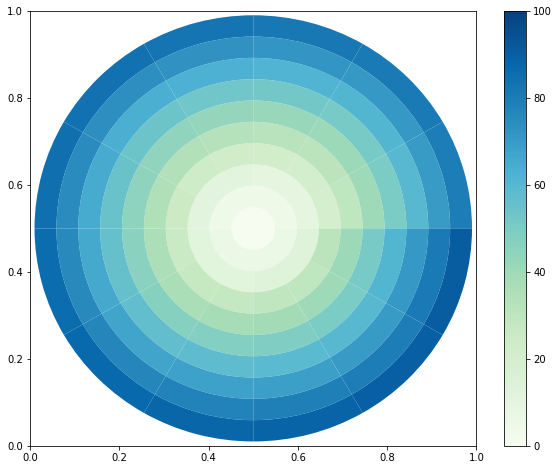

In [31]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, scale= 0.49, figsize=(10,8), alpha=1.0)

In [32]:
KRES = select_rphi_sectors(dst, DT, E, Q, W, verbose = False)

### Time 

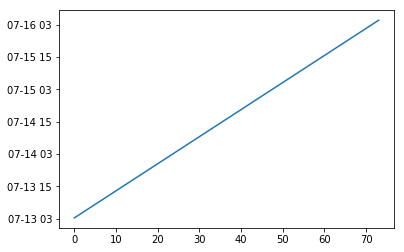

In [33]:
plt.plot(krTimes.timeStamps)

### Event distribution

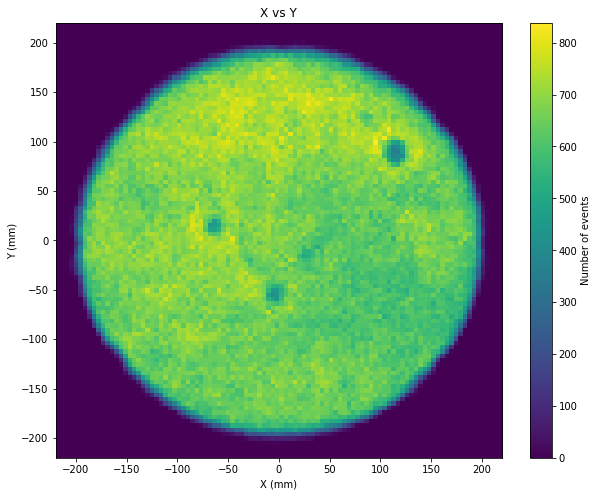

In [34]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 172196.0


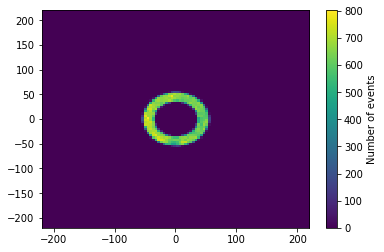

In [35]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=2)

number of events in sector = 35442.0
number of events in sector = 103164.0
number of events in sector = 172196.0
number of events in sector = 241137.0
number of events in sector = 314001.0
number of events in sector = 383883.0
number of events in sector = 459039.0
number of events in sector = 531983.0
number of events in sector = 599579.0
number of events in sector = 660325.0


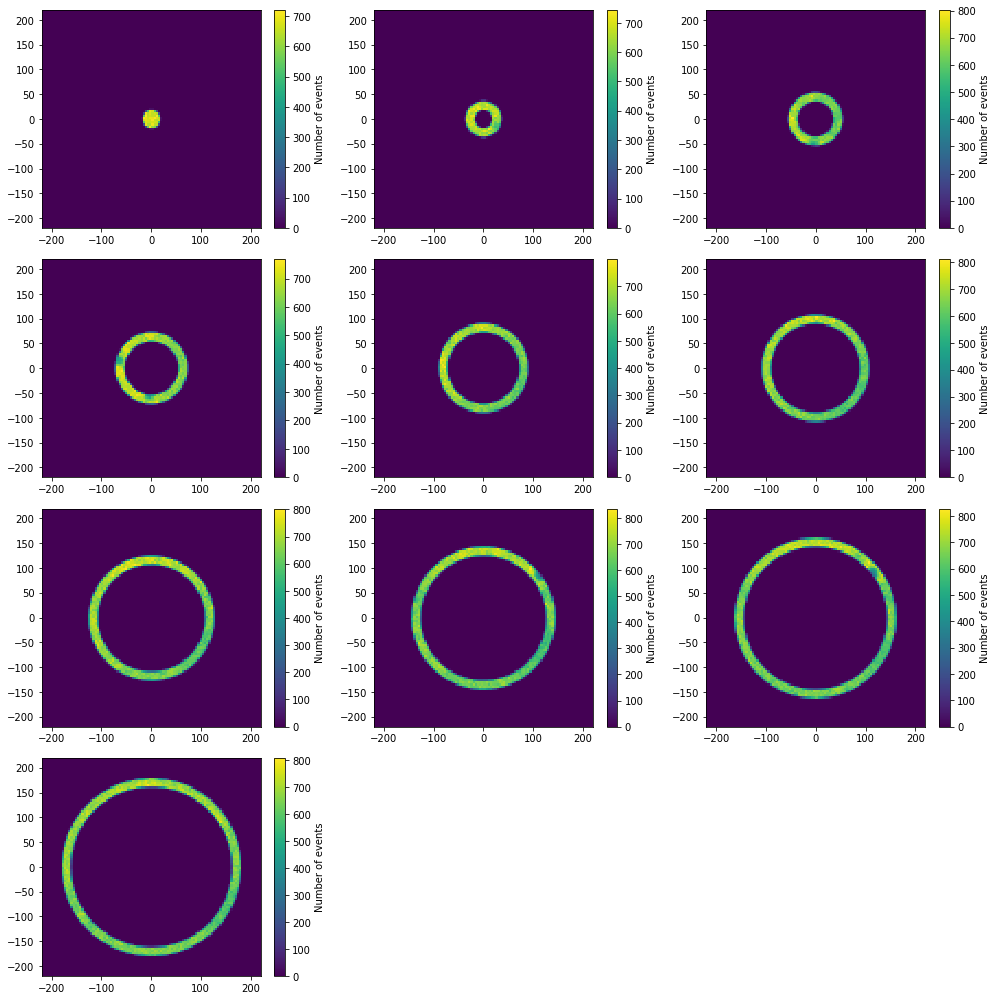

In [36]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y)

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [37]:
XT = 10000

In [38]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
                    

wedge = 0: chi2 =     0.91 ; e0 = 11818.47 +-  17.33; lt =  2632.90 +-  64.26;


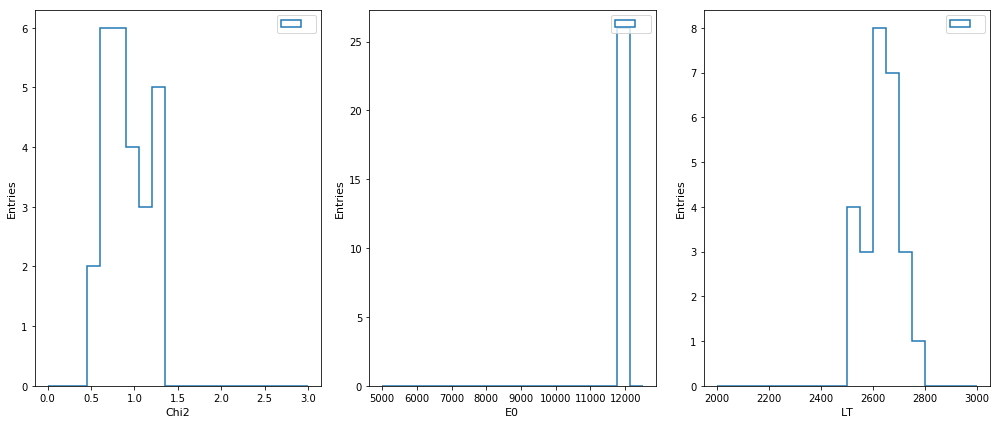

In [42]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

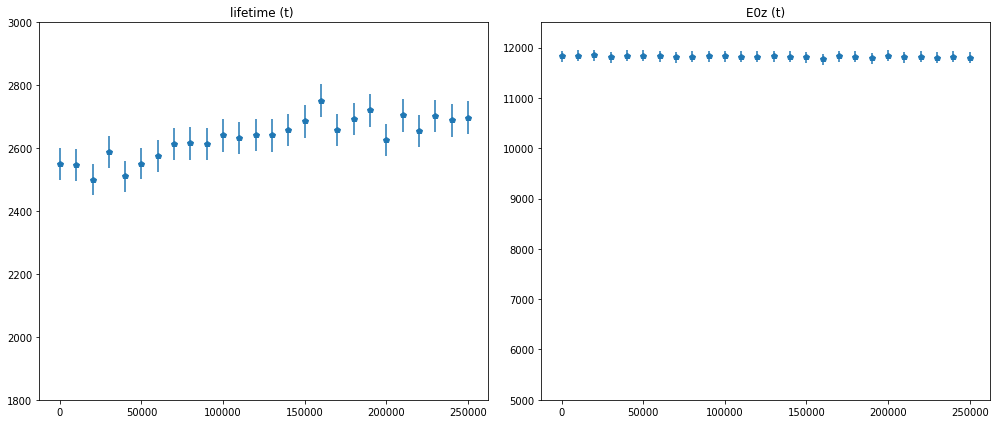

In [43]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [44]:
fps = fit_fcs_in_sectors(1, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

wedge = 0: chi2 =     0.98 ; e0 = 11777.96 +-  16.48; lt =  2621.81 +-  66.30;
wedge = 1: chi2 =     0.89 ; e0 = 11738.39 +-  15.71; lt =  2609.64 +-  53.38;


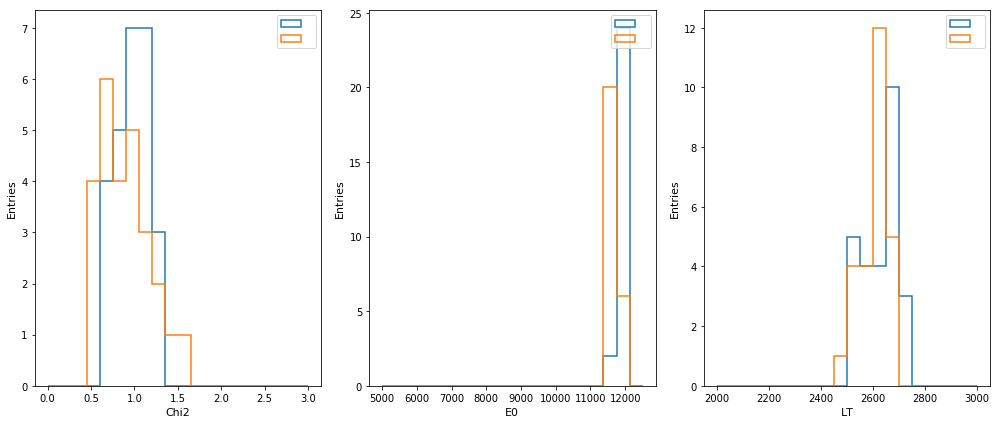

In [45]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts )

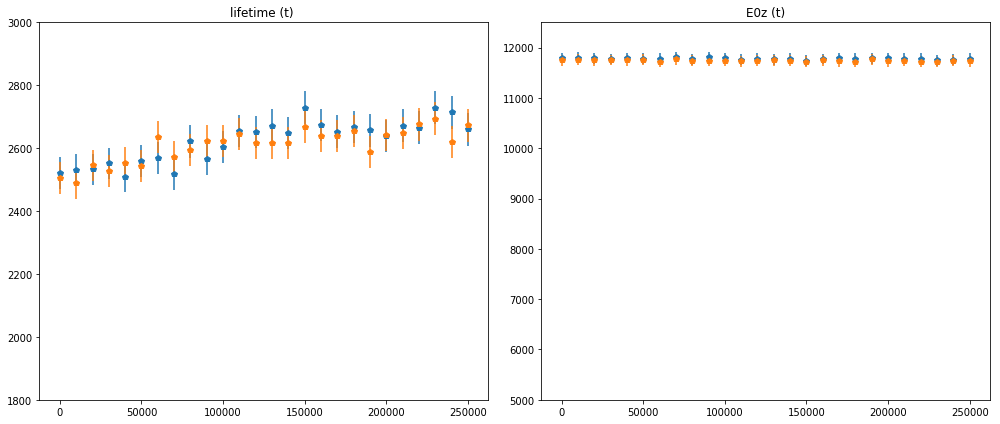

In [46]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [47]:
fps = fit_fcs_in_sectors(2, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



wedge = 0: chi2 =     0.92 ; e0 = 11953.50 +-  13.09; lt =  2544.07 +-  47.52;
wedge = 1: chi2 =     0.92 ; e0 = 11686.81 +-  14.18; lt =  2579.42 +-  60.92;
wedge = 2: chi2 =     0.91 ; e0 = 11458.43 +-  15.02; lt =  2613.42 +-  45.81;
wedge = 3: chi2 =     0.94 ; e0 = 11703.92 +-  13.71; lt =  2561.22 +-  45.59;


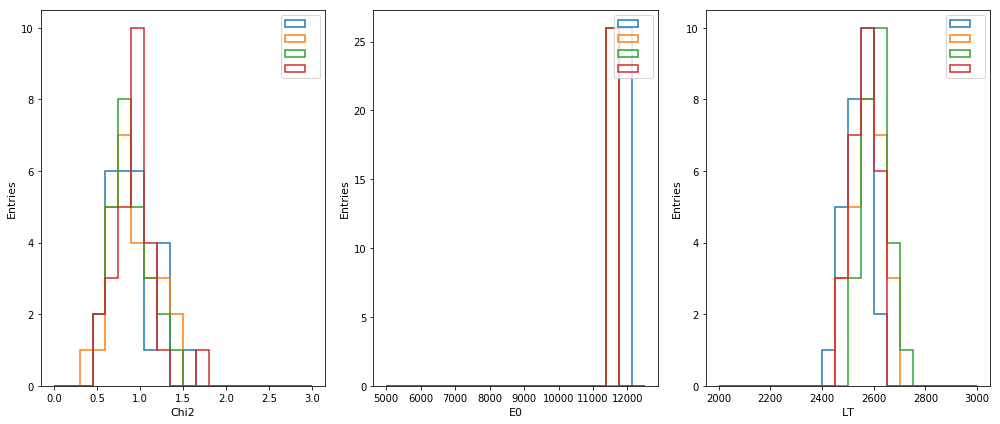

In [48]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

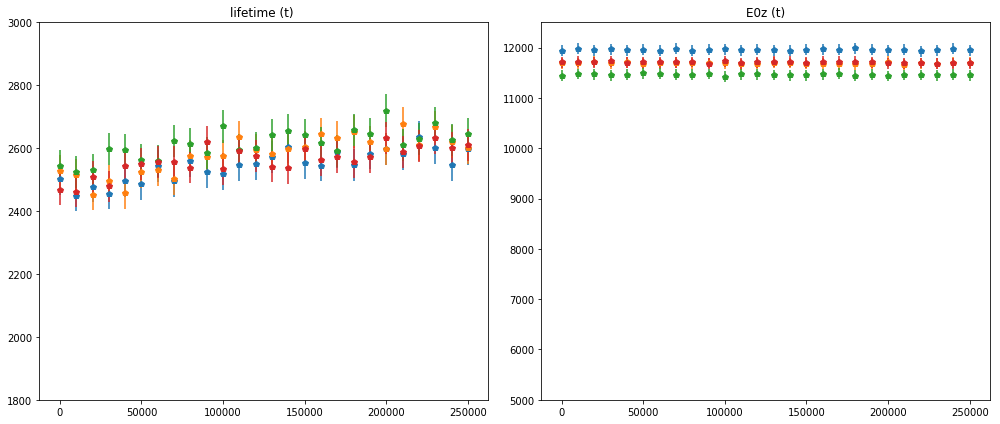

In [49]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [50]:
fps = fit_fcs_in_sectors(3, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.89 ; e0 = 11984.13 +-  17.60; lt =  2508.83 +-  52.36;
wedge = 1: chi2 =     0.89 ; e0 = 12215.96 +-  19.66; lt =  2478.22 +-  49.69;
wedge = 2: chi2 =     0.89 ; e0 = 11868.13 +-  26.09; lt =  2507.70 +-  62.27;
wedge = 3: chi2 =     0.93 ; e0 = 11619.01 +-  15.88; lt =  2522.19 +-  43.26;
wedge = 4: chi2 =     0.94 ; e0 = 11542.12 +-  22.42; lt =  2545.22 +-  59.19;
wedge = 5: chi2 =     0.89 ; e0 = 11464.08 +-  24.35; lt =  2605.69 +-  76.45;
wedge = 6: chi2 =     0.82 ; e0 = 11238.00 +-  16.90; lt =  2688.58 +-  47.24;
wedge = 7: chi2 =     0.91 ; e0 = 11233.20 +-  17.72; lt =  2492.69 +-  49.78;
wedge = 8: chi2 =     0.96 ; e0 = 11222.66 +-  16.70; lt =  2398.05 +-  50.34;
wedge = 9: chi2 =     0.90 ; e0 = 11412.24 +-  16.05; lt =  2408.80 +-  52.49;
wedge = 10: chi2 =     0.90 ; e0 = 11590.92 +-  19.54; lt =  2516.19 +-  54.27;
wedge = 11: chi2 =     0.87 ; e0 = 11757.78 +-  13.85; lt =  2521.86 +-  45.73;


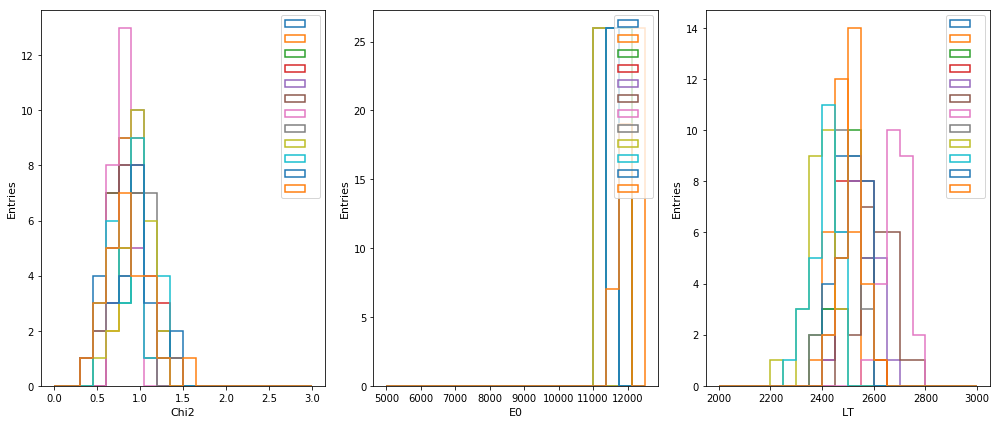

In [51]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

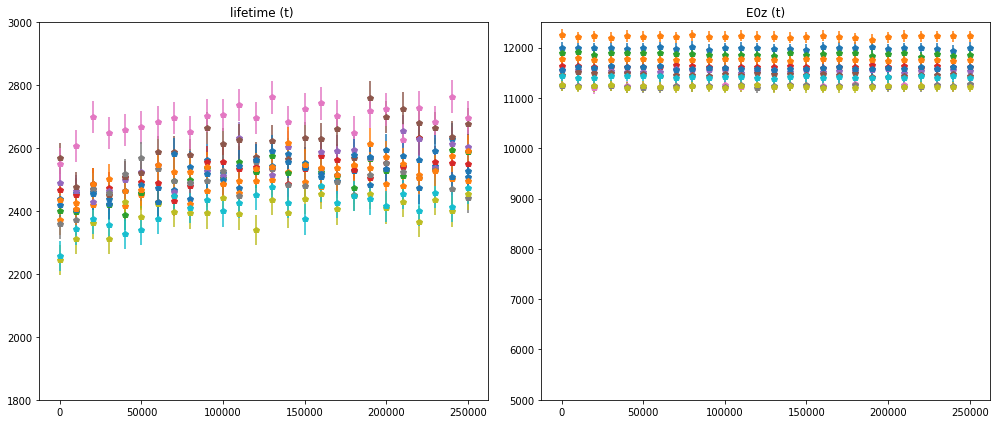

In [52]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [53]:
fps = fit_fcs_in_sectors(4, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.86 ; e0 = 11878.26 +-  14.03; lt =  2510.94 +-  44.67;
wedge = 1: chi2 =     0.87 ; e0 = 11919.43 +-  23.69; lt =  2511.15 +-  50.29;
wedge = 2: chi2 =     0.90 ; e0 = 11644.03 +-  15.28; lt =  2524.68 +-  42.98;
wedge = 3: chi2 =     0.85 ; e0 = 11455.83 +-  16.05; lt =  2504.53 +-  42.48;
wedge = 4: chi2 =     0.89 ; e0 = 11323.95 +-  22.03; lt =  2511.63 +-  56.12;
wedge = 5: chi2 =     0.85 ; e0 = 11129.82 +-  18.90; lt =  2638.70 +-  72.36;
wedge = 6: chi2 =     0.91 ; e0 = 11016.32 +-  16.23; lt =  2674.03 +-  54.49;
wedge = 7: chi2 =     0.91 ; e0 = 11029.23 +-  18.26; lt =  2378.43 +-  44.33;
wedge = 8: chi2 =     0.91 ; e0 = 10911.33 +-  18.47; lt =  2296.71 +-  37.38;
wedge = 9: chi2 =     0.96 ; e0 = 11132.52 +-  22.66; lt =  2321.18 +-  59.17;
wedge = 10: chi2 =     0.92 ; e0 = 11370.79 +-  19.29; lt =  2437.07 +-  57.23;
wedge = 11: chi2 =     0.90 ; e0 = 11600.16 +-  17.48; lt =  2514.92 +-  44.15;


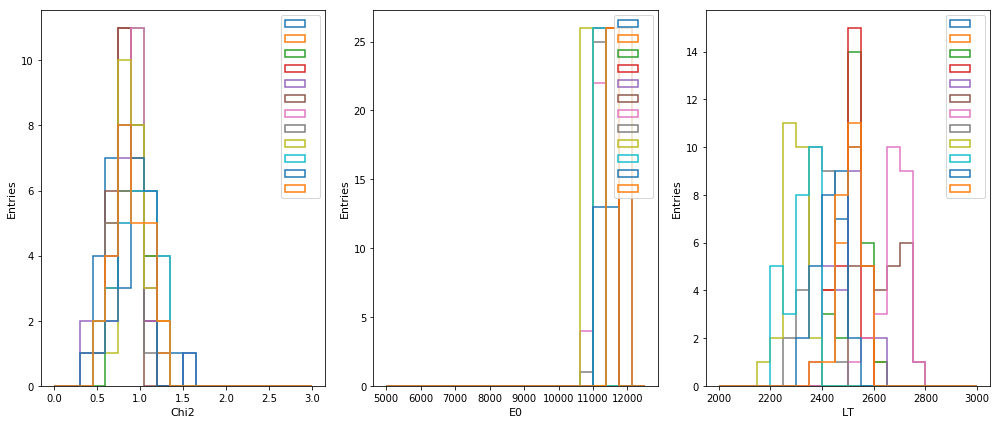

In [54]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

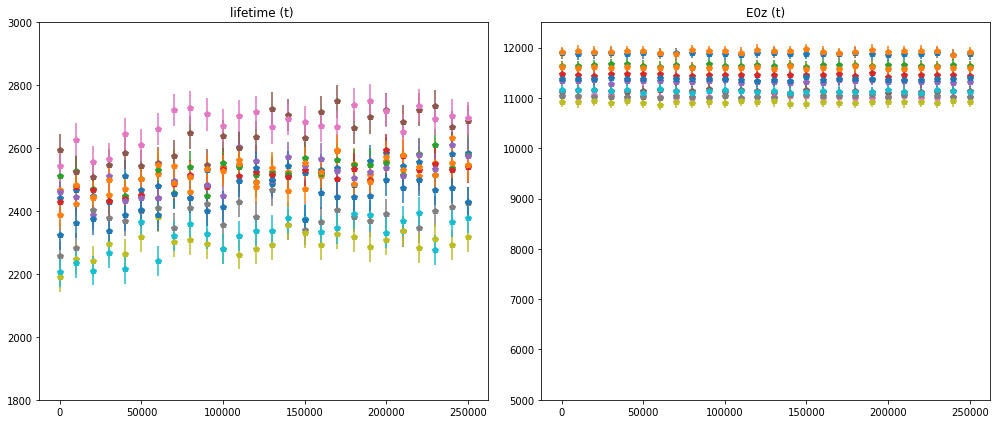

In [55]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [56]:
fps = fit_fcs_in_sectors(5, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.90 ; e0 = 11632.31 +-  15.08; lt =  2529.45 +-  42.12;
wedge = 1: chi2 =     0.87 ; e0 = 11604.45 +-  13.15; lt =  2536.29 +-  39.25;
wedge = 2: chi2 =     1.01 ; e0 = 11612.38 +-  17.57; lt =  2447.96 +-  49.50;
wedge = 3: chi2 =     0.92 ; e0 = 11361.34 +-  15.86; lt =  2437.51 +-  45.29;
wedge = 4: chi2 =     0.93 ; e0 = 11016.61 +-  15.71; lt =  2517.65 +-  57.64;
wedge = 5: chi2 =     0.91 ; e0 = 10880.86 +-  16.10; lt =  2608.65 +-  72.13;
wedge = 6: chi2 =     1.01 ; e0 = 10760.88 +-  16.66; lt =  2637.17 +-  58.56;
wedge = 7: chi2 =     0.91 ; e0 = 10734.55 +-  15.37; lt =  2302.54 +-  36.00;
wedge = 8: chi2 =     0.96 ; e0 = 10661.68 +-  13.79; lt =  2206.90 +-  32.22;
wedge = 9: chi2 =     1.08 ; e0 = 10858.89 +-  20.24; lt =  2232.22 +-  40.38;
wedge = 10: chi2 =     1.05 ; e0 = 11042.06 +-  13.00; lt =  2392.78 +-  54.44;
wedge = 11: chi2 =     0.93 ; e0 = 11273.53 +-  15.92; lt =  2518.90 +-  42.41;


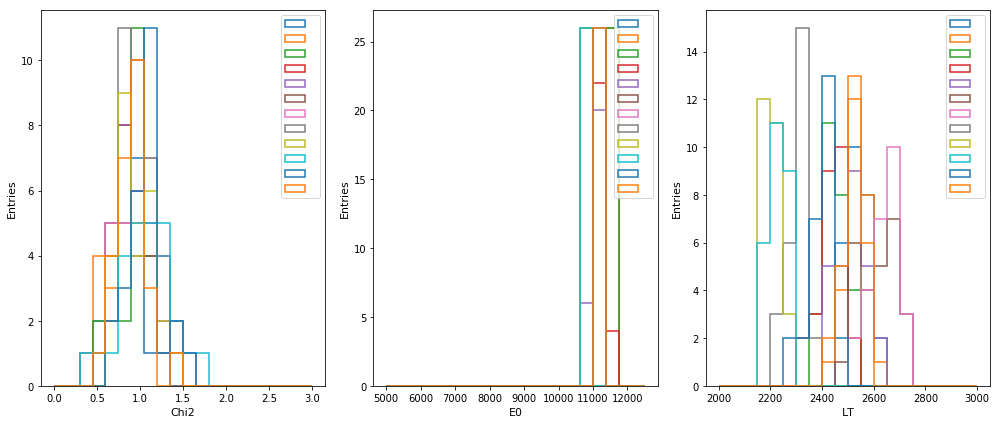

In [57]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

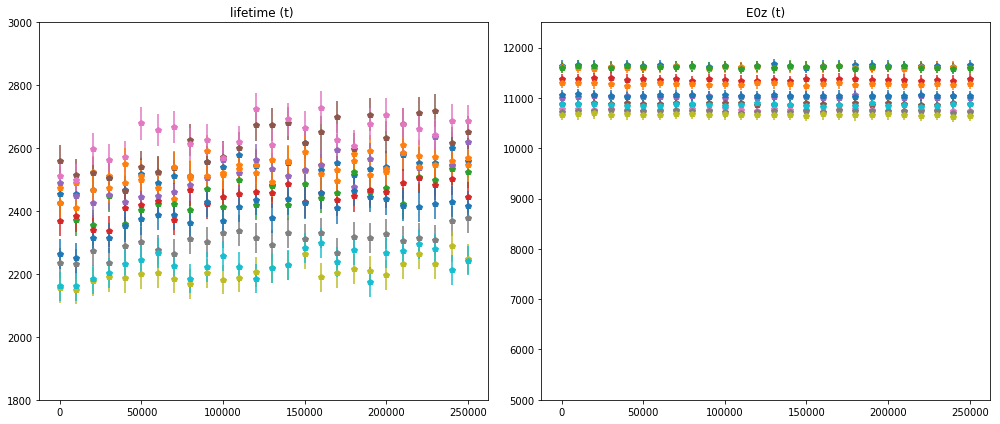

In [58]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [59]:
fps = fit_fcs_in_sectors(6, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.83 ; e0 = 11445.90 +-  15.75; lt =  2503.66 +-  42.64;
wedge = 1: chi2 =     0.93 ; e0 = 11479.63 +-  13.92; lt =  2495.74 +-  34.79;
wedge = 2: chi2 =     0.99 ; e0 = 11440.55 +-  12.93; lt =  2422.61 +-  24.01;
wedge = 3: chi2 =     1.06 ; e0 = 11166.01 +-  14.12; lt =  2398.46 +-  32.39;
wedge = 4: chi2 =     0.94 ; e0 = 10782.05 +-  14.50; lt =  2460.89 +-  45.48;
wedge = 5: chi2 =     0.98 ; e0 = 10613.21 +-  14.33; lt =  2592.47 +-  69.43;
wedge = 6: chi2 =     0.92 ; e0 = 10470.70 +-  14.57; lt =  2612.43 +-  50.24;
wedge = 7: chi2 =     0.90 ; e0 = 10407.25 +-  15.87; lt =  2236.65 +-  32.55;
wedge = 8: chi2 =     0.97 ; e0 = 10316.30 +-  14.35; lt =  2144.74 +-  25.04;
wedge = 9: chi2 =     1.00 ; e0 = 10473.50 +-  12.45; lt =  2182.01 +-  23.99;
wedge = 10: chi2 =     1.03 ; e0 = 10704.25 +-  18.63; lt =  2330.89 +-  48.64;
wedge = 11: chi2 =     0.88 ; e0 = 10938.75 +-   8.77; lt =  2521.76 +-  29.11;


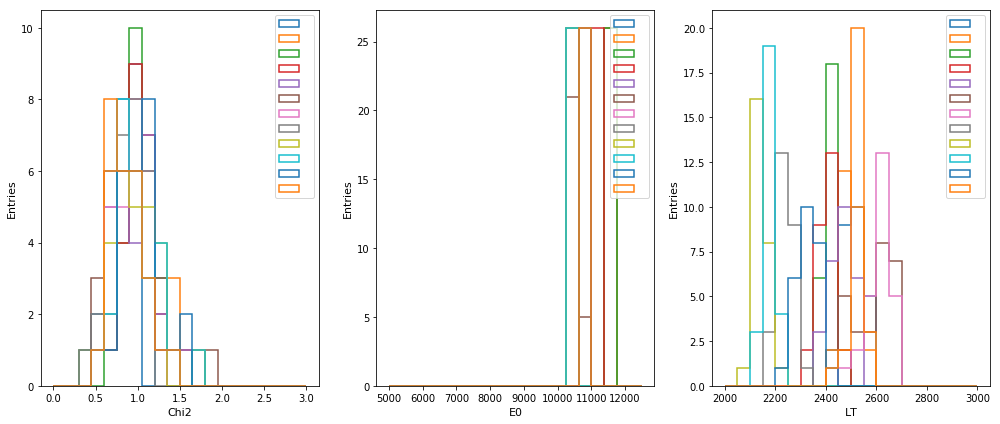

In [60]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

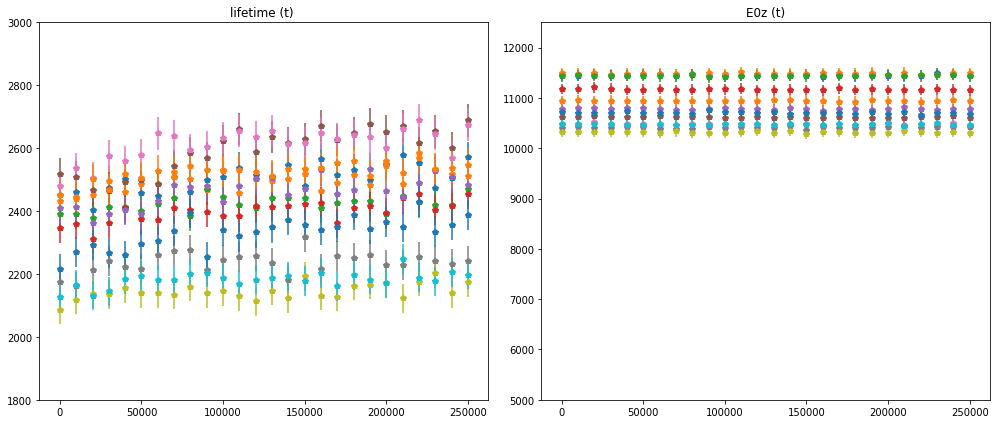

In [61]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [62]:
fps = fit_fcs_in_sectors(7, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.91 ; e0 = 11147.68 +-  17.83; lt =  2498.59 +-  45.53;
wedge = 1: chi2 =     0.97 ; e0 = 11294.25 +-  11.90; lt =  2455.84 +-  30.54;
wedge = 2: chi2 =     1.02 ; e0 = 11185.75 +-  11.61; lt =  2357.69 +-  29.37;
wedge = 3: chi2 =     1.06 ; e0 = 10843.21 +-  19.20; lt =  2347.27 +-  32.95;
wedge = 4: chi2 =     0.88 ; e0 = 10424.55 +-  14.30; lt =  2416.28 +-  37.30;
wedge = 5: chi2 =     0.86 ; e0 = 10273.36 +-  13.73; lt =  2568.50 +-  63.78;
wedge = 6: chi2 =     0.94 ; e0 = 10122.73 +-  13.98; lt =  2553.80 +-  45.82;
wedge = 7: chi2 =     0.96 ; e0 =  9977.60 +-  13.38; lt =  2191.34 +-  33.37;
wedge = 8: chi2 =     0.92 ; e0 =  9805.51 +-  12.76; lt =  2067.66 +-  28.78;
wedge = 9: chi2 =     0.88 ; e0 =  9964.03 +-  16.13; lt =  2123.92 +-  37.60;
wedge = 10: chi2 =     1.06 ; e0 = 10323.01 +-  14.08; lt =  2255.44 +-  39.14;
wedge = 11: chi2 =     0.87 ; e0 = 10553.60 +-  17.88; lt =  2532.26 +-  49.54;


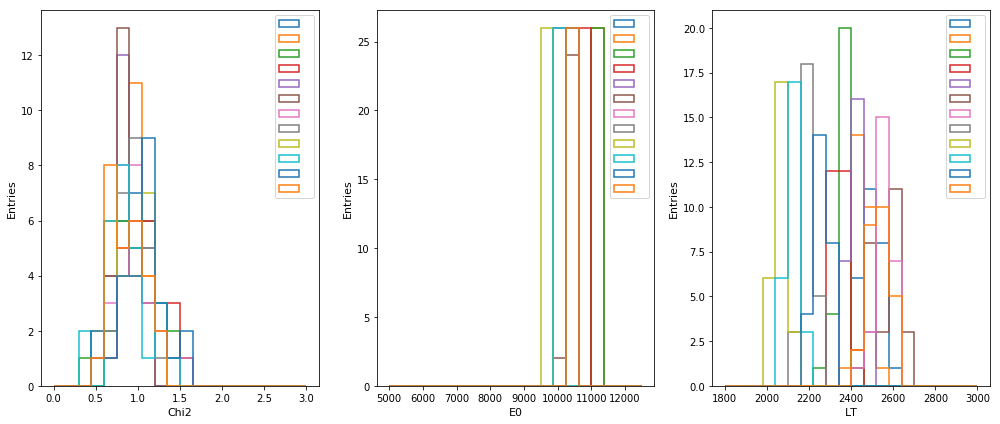

In [63]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

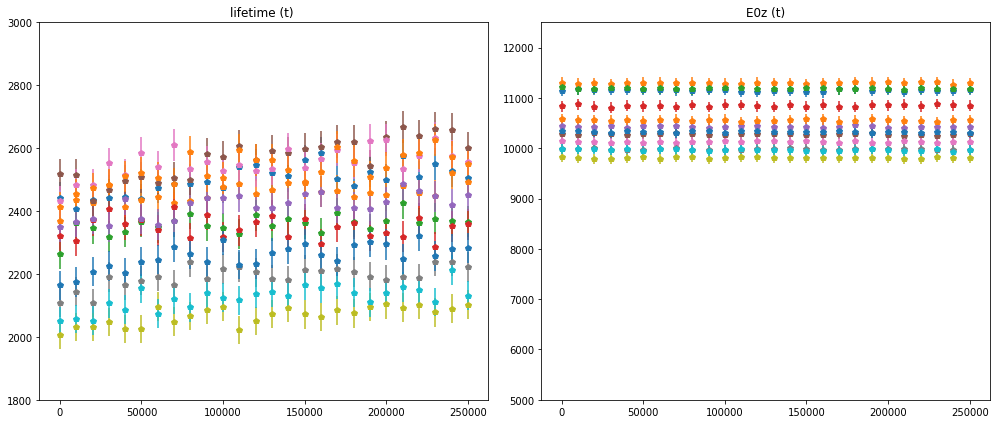

In [64]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [65]:
fps = fit_fcs_in_sectors(8, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.96 ; e0 = 10717.41 +-  14.08; lt =  2491.79 +-  46.53;
wedge = 1: chi2 =     0.95 ; e0 = 10920.85 +-  16.20; lt =  2419.14 +-  41.52;
wedge = 2: chi2 =     0.86 ; e0 = 10737.98 +-  12.24; lt =  2341.46 +-  23.35;
wedge = 3: chi2 =     0.90 ; e0 = 10327.41 +-  15.20; lt =  2303.01 +-  30.94;
wedge = 4: chi2 =     0.91 ; e0 =  9908.08 +-  17.17; lt =  2385.66 +-  39.03;
wedge = 5: chi2 =     0.90 ; e0 =  9832.91 +-  14.45; lt =  2514.75 +-  63.63;
wedge = 6: chi2 =     0.85 ; e0 =  9629.23 +-  19.23; lt =  2530.97 +-  48.47;
wedge = 7: chi2 =     0.94 ; e0 =  9389.29 +-  14.13; lt =  2184.34 +-  42.28;
wedge = 8: chi2 =     0.84 ; e0 =  9187.80 +-  19.34; lt =  1960.89 +-  35.91;
wedge = 9: chi2 =     0.87 ; e0 =  9370.17 +-  16.40; lt =  2012.26 +-  26.88;
wedge = 10: chi2 =     0.90 ; e0 =  9834.57 +-  15.95; lt =  2175.02 +-  31.16;
wedge = 11: chi2 =     0.95 ; e0 = 10089.93 +-  14.50; lt =  2555.36 +-  47.29;


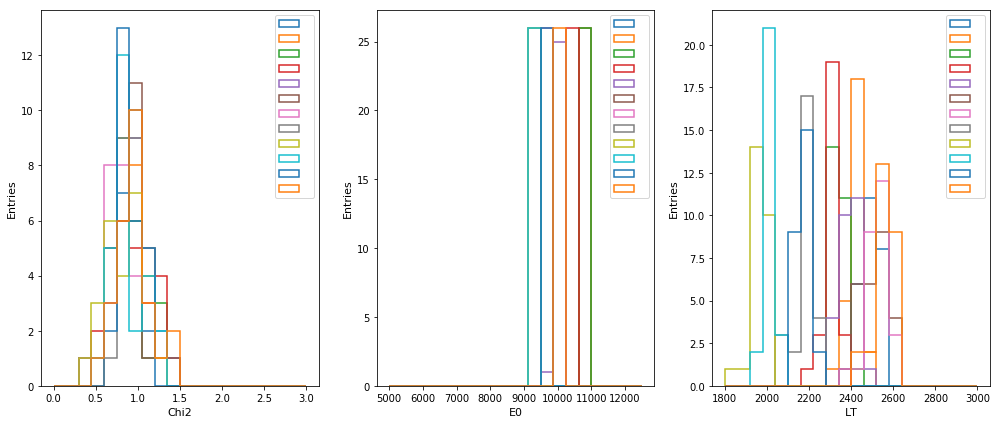

In [66]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

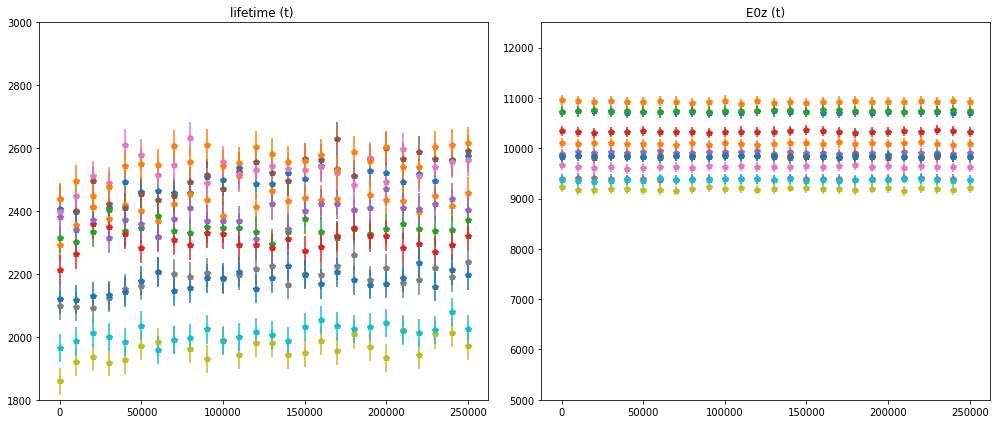

In [67]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [68]:
fps = fit_fcs_in_sectors(9, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.80 ; e0 = 10106.99 +-  14.54; lt =  2456.57 +-  42.73;
wedge = 1: chi2 =     0.92 ; e0 = 10333.72 +-  16.71; lt =  2328.64 +-  36.30;
wedge = 2: chi2 =     0.87 ; e0 = 10099.03 +-  16.91; lt =  2295.91 +-  34.76;
wedge = 3: chi2 =     0.94 ; e0 =  9618.98 +-  13.05; lt =  2264.43 +-  29.84;
wedge = 4: chi2 =     0.88 ; e0 =  9301.18 +-  19.86; lt =  2308.07 +-  37.24;
wedge = 5: chi2 =     0.88 ; e0 =  9164.07 +-  19.21; lt =  2462.13 +-  71.88;
wedge = 6: chi2 =     0.99 ; e0 =  9037.48 +-  20.45; lt =  2434.30 +-  40.66;
wedge = 7: chi2 =     0.94 ; e0 =  8687.17 +-  25.49; lt =  2093.02 +-  37.02;
wedge = 8: chi2 =     0.91 ; e0 =  8409.36 +-  17.05; lt =  1890.40 +-  32.44;
wedge = 9: chi2 =     0.85 ; e0 =  8632.04 +-  17.30; lt =  1923.61 +-  24.73;
wedge = 10: chi2 =     0.89 ; e0 =  9091.41 +-  22.69; lt =  2073.60 +-  42.40;
wedge = 11: chi2 =     0.90 ; e0 =  9571.38 +-  15.22; lt =  2425.47 +-  38.09;


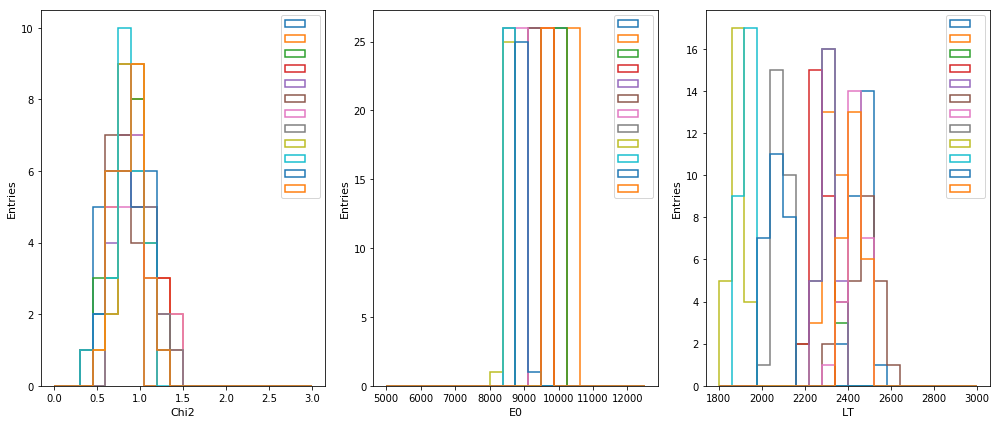

In [70]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

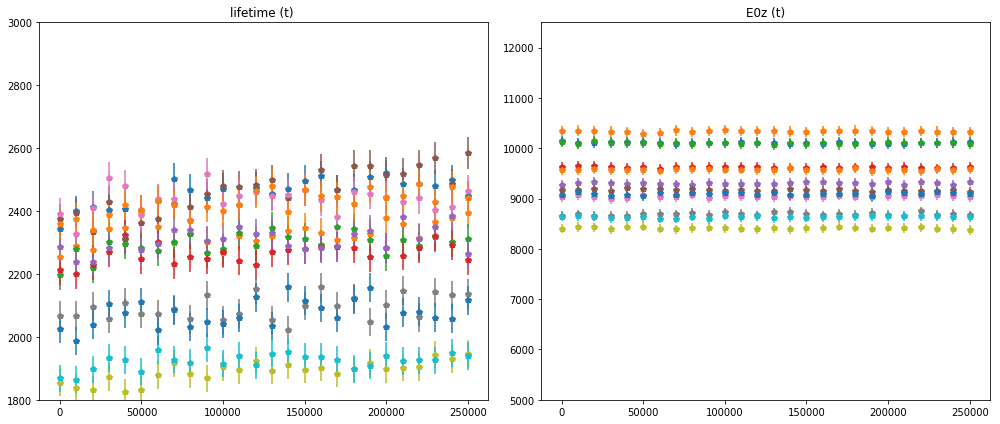

In [71]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. LT has an structure, splitting in some sectors in two peaks.

## Maps

In [73]:
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = (50,550),
               range_e     = (5000, 13000),
               range_chi2  = (0,3),
               range_lt    = (1800, 3000),
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = True)

Fitting sector 0
 number of wedges in sector 1
Fitting sector 1
 number of wedges in sector 2
Fitting sector 2
 number of wedges in sector 4
Fitting sector 3
 number of wedges in sector 12
Fitting sector 4
 number of wedges in sector 12
Fitting sector 5
 number of wedges in sector 12
Fitting sector 6
 number of wedges in sector 12
Fitting sector 7
 number of wedges in sector 12
Fitting sector 8
 number of wedges in sector 12
Fitting sector 9
 number of wedges in sector 12


In [74]:
ts = fmap[0][0].ts

In [75]:
ts

array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
       160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000,
       240000, 250000])

In [76]:
len(ts)

26

In [80]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

In [81]:
am = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))

In [82]:
asm = relative_errors(am)

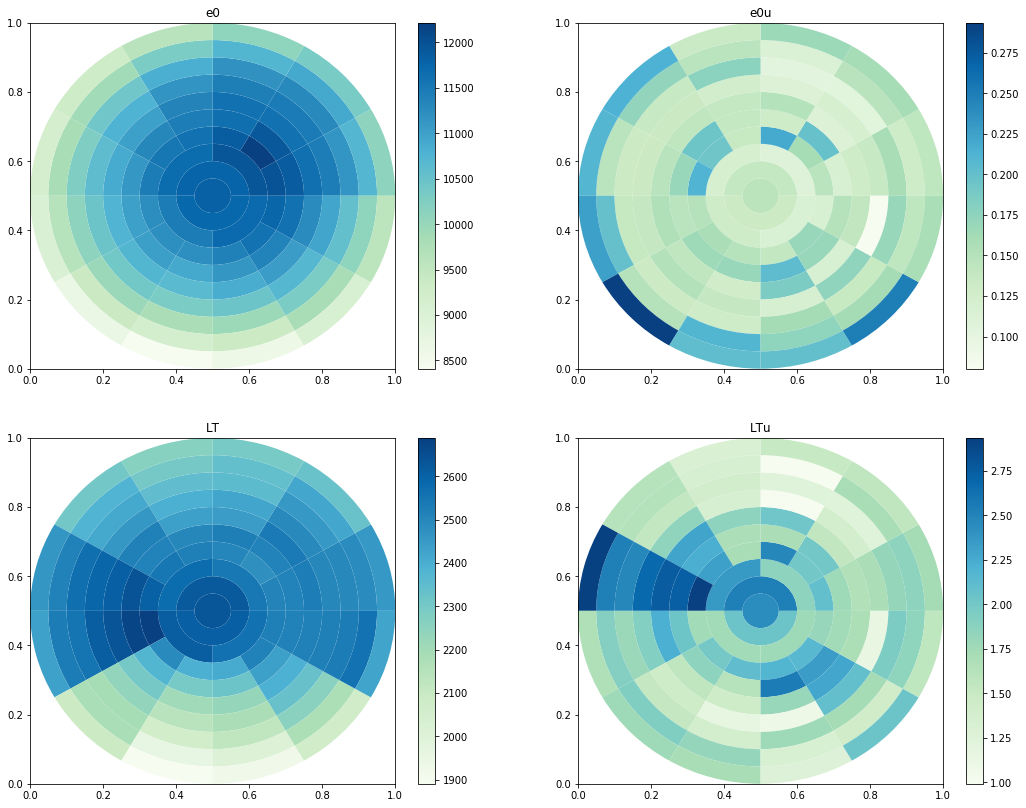

In [87]:
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

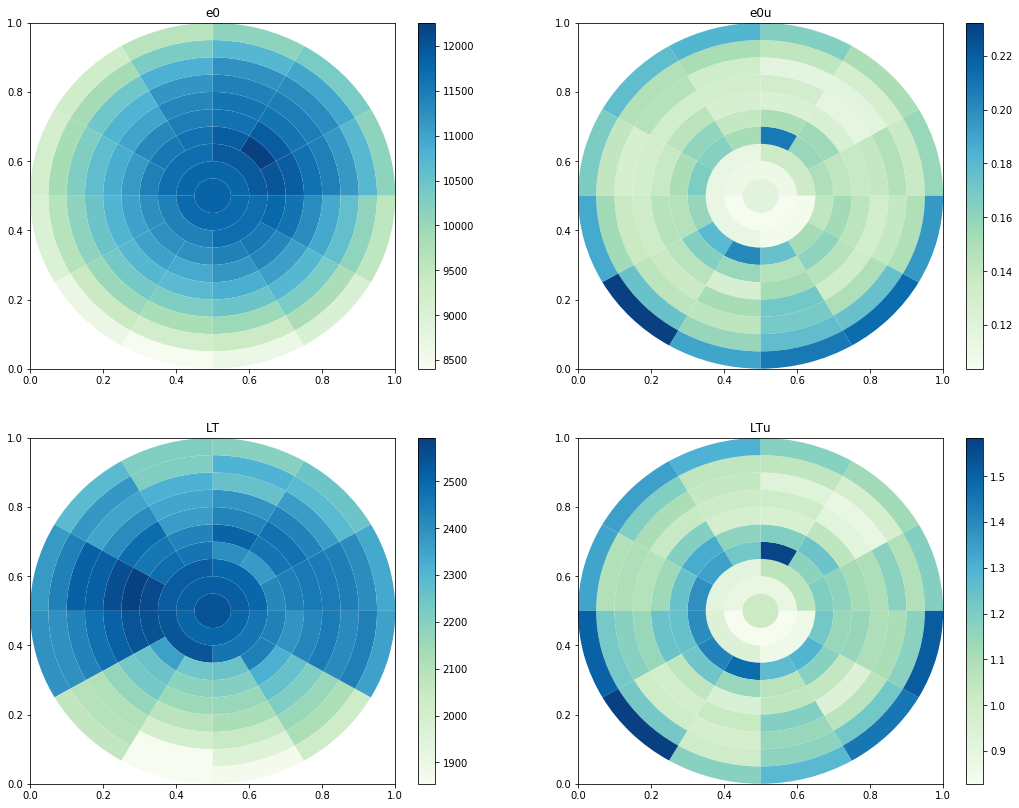

In [88]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

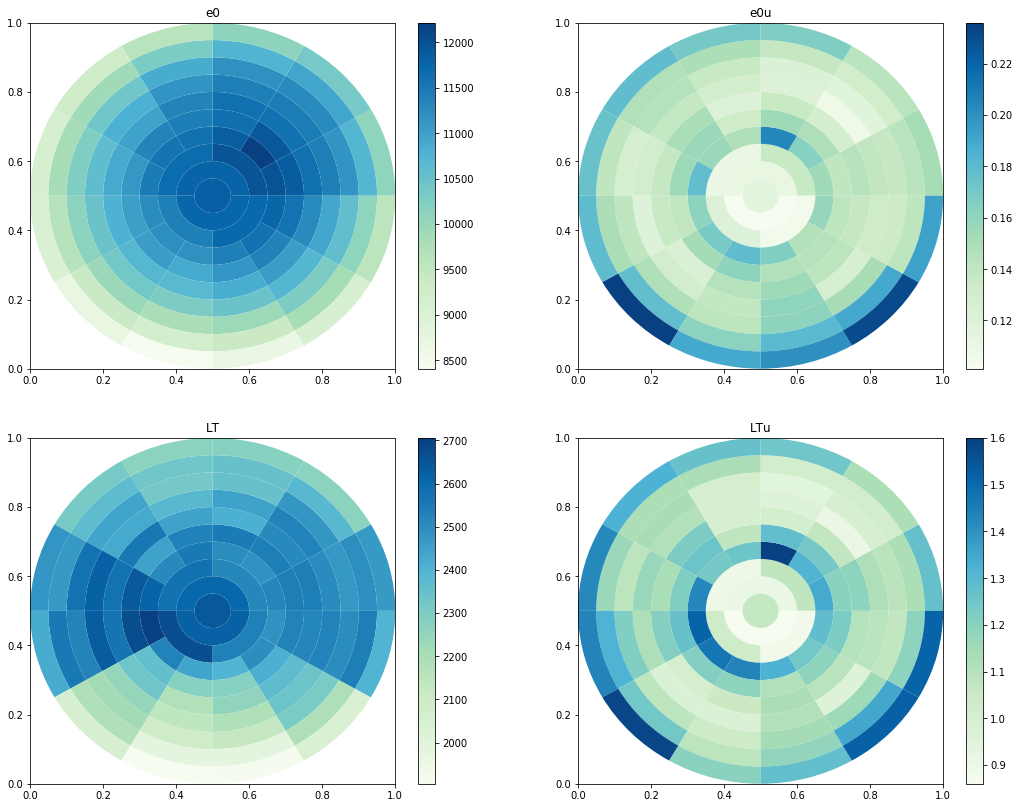

In [89]:
am = amap_from_tsmap(tsm, 
                     ts = 10, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

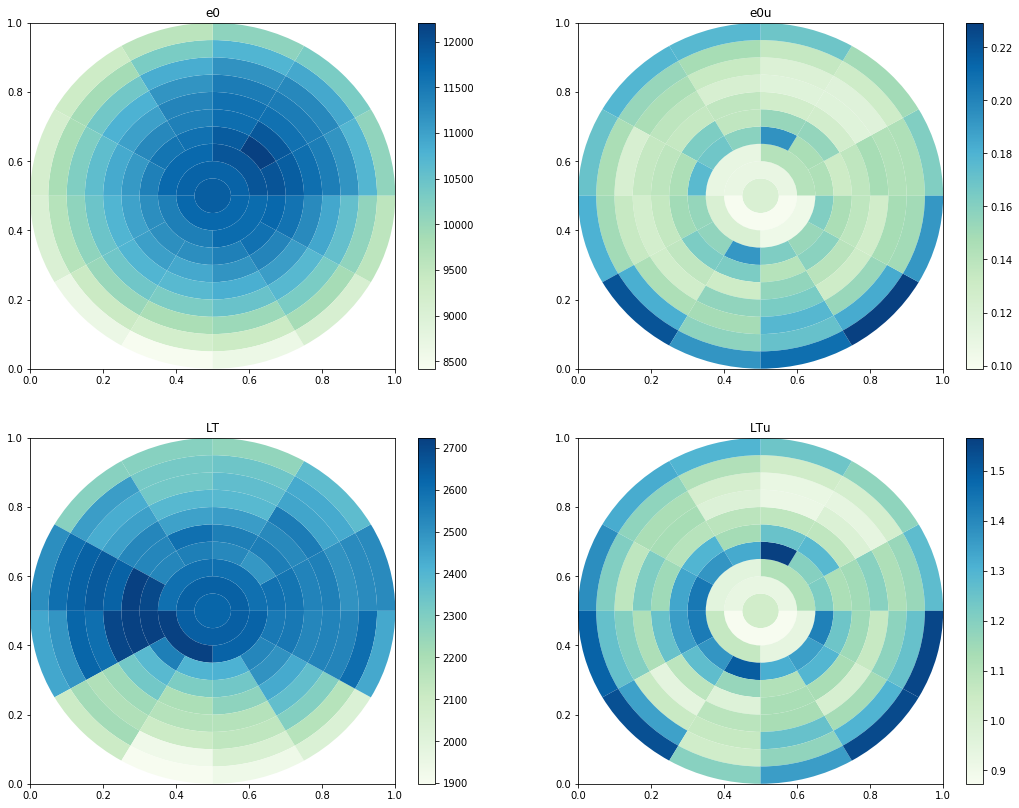

In [90]:
am = amap_from_tsmap(tsm, 
                     ts = 20, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm, verbose = True,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

In [59]:
invalid = ~valid
mask = valid

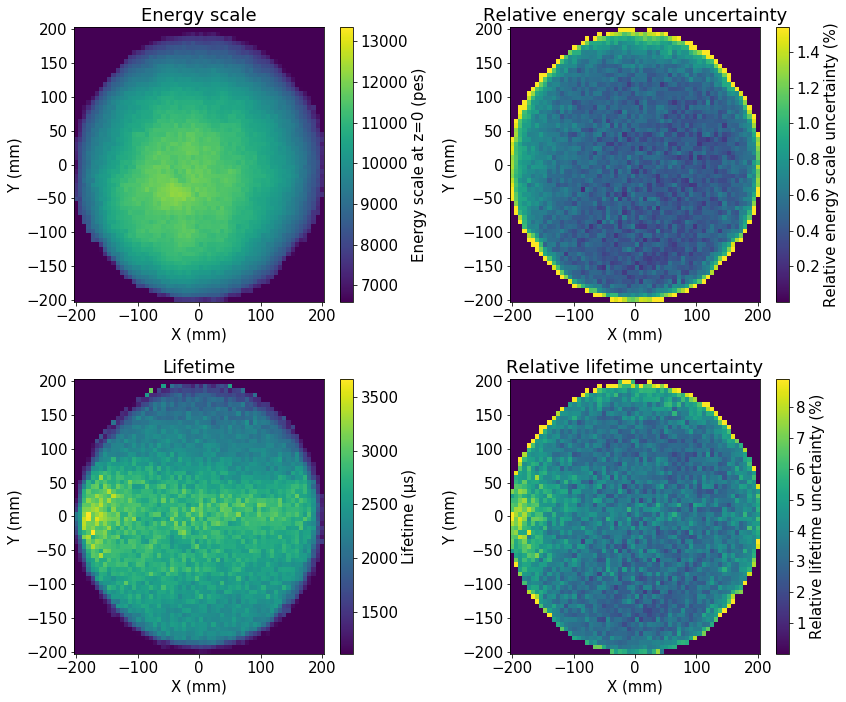

In [60]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="viridis", mask=valid)
                         

(1.2341219470183695, 0.66563217860108326)

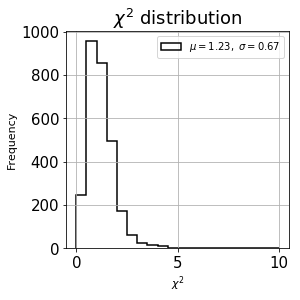

In [61]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

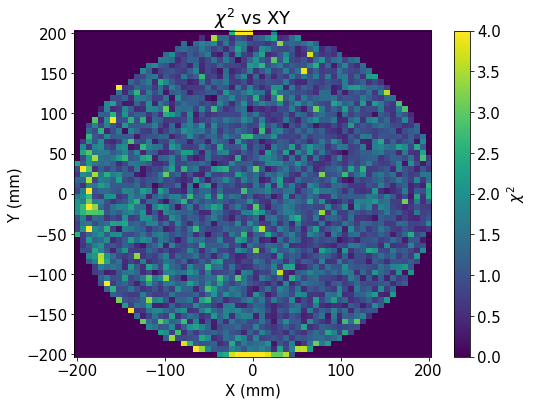

In [62]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Produce HDF5 output

In [72]:
nevt = nEvt.fid

In [73]:
print(map_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6224_0000_29999.h5


In [74]:
with tb.open_file(map_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY

